# 1. Importing dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import os
import scipy
import multiprocessing as mp

from PIL import Image

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [17]:
random_seed = 997
# seed added for results reproducibility
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# 2. Image generation by augmentation

In [3]:
# GLOBALS
IMG_X, IMG_Y = 320, 213

In [4]:
def augment_image_for_country(
        country, directories, datagen, num_augmented_images=5
    ) -> None:
    country_input_path = os.path.join(directories['source_dir'], country)
    country_output_path = os.path.join(directories['augmented_dir'], country)
    os.makedirs(country_output_path, exist_ok=True)

    for image_name in os.listdir(country_input_path):
        img_path = os.path.join(country_input_path, image_name)
        img = load_img(img_path)
        img = img.resize((IMG_X, IMG_Y))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        # to size: (1, width, height, channels)
        
        i = 0
        for batch in datagen.flow(
            x, batch_size=1, save_to_dir=country_output_path, save_prefix='aug', save_format='jpeg'
        ):
            i += 1
            if i >= num_augmented_images:
                break

def augment_images(directories, data_generator, num_augmented_images=5) -> None:
    countries = os.listdir(directories['source_dir'])
    pool = mp.Pool(mp.cpu_count())
    pool.starmap(
        augment_image_for_country,
        [(country, directories, data_generator, num_augmented_images) for country in countries]
    )
    pool.close()
    pool.join()

In [5]:
# obj for augmentation:
datagen = ImageDataGenerator(
    rotation_range=90.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.4,
    zoom_range=[0.8, 1.2],
    channel_shift_range=51.0, # coding 0-255
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
dir_dict = {
    'source_dir': 'data/country_flag',
    'augmented_dir': 'data/augmented_flags',
    'tfrecords': 'data/tfrecords',
    'train_tfrecord': 'data/tfrecords/train.tfrecord',
    'val_tfrecord': 'data/tfrecords/val.tfrecord',
    'test_tfrecord': 'data/tfrecords/test.tfrecord',
}

In [7]:
if not os.path.exists(dir_dict['augmented_dir']):
    os.makedirs(dir_dict['augmented_dir'])
    augment_images(dir_dict, datagen, num_augmented_images=200)
    print("Augmentation completed.")

# 3. Creation of TFRecords

In [8]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, label):
    feature = {
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(images, labels, output_path):
    """Function to write images to TFRecord."""
    with tf.io.TFRecordWriter(output_path) as writer:
        for img_path, label in zip(images, labels):
            img = Image.open(img_path)
            img = img.resize((IMG_X, IMG_Y))
            img = img.convert('RGB')
            img_byte_arr = img.tobytes()

            tf_example = image_example(img_byte_arr, label)
            writer.write(tf_example.SerializeToString())

def convert_to_tfrecord(directories, test_size=0.2, val_size=0.2):
    countries = os.listdir(directories['augmented_dir'])
    label_map = {country: idx for idx, country in enumerate(countries)}

    all_images = []
    all_labels = []

    for country, label in label_map.items():
        country_input_path = os.path.join(directories['augmented_dir'], country)
        for image_name in os.listdir(country_input_path):
            img_path = os.path.join(country_input_path, image_name)
            all_images.append(img_path)
            all_labels.append(label)
        
    train_images, test_images, train_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=test_size, stratify=all_labels
    )
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=val_size, stratify=train_labels
    )

    write_tfrecord(train_images, train_labels, directories['train_tfrecord'])
    write_tfrecord(val_images, val_labels, directories['val_tfrecord'])
    write_tfrecord(test_images, test_labels, directories['test_tfrecord'])

In [9]:
if not os.path.exists(dir_dict['tfrecords']):
    os.makedirs(dir_dict['tfrecords'])
    convert_to_tfrecord(dir_dict, test_size=0.1, val_size=0.1)
    print("TFRecord conversion completed.")

TFRecord conversion completed.


# 4. Reading TFRecords

In [10]:
def _parse_function(proto):
    """ Function is used to parse the example. Returns respectively image and its label. """
    keys_to_features = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    
    image = tf.io.decode_raw(parsed_features['image_raw'], tf.uint8)
    image = tf.reshape(image, [IMG_Y, IMG_X, 3])
    # size of original shape (213, 320, 3)
    label = tf.cast(parsed_features['label'], tf.int32)
    
    return image, label

def load_tfrecord_dataset(tfrecord_paths, batch_size=32):
    """ Creates a dataset from the TFRecord files. """
    dataset = tf.data.TFRecordDataset(tfrecord_paths)
    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size)
    return dataset

In [11]:
train_dataset = load_tfrecord_dataset(dir_dict['train_tfrecord'])
val_dataset = load_tfrecord_dataset(dir_dict['val_tfrecord'])
test_dataset = load_tfrecord_dataset(dir_dict['test_tfrecord'])

In [12]:
for images, labels in train_dataset.take(1):
    print(images.shape, '\n', labels)

(32, 213, 320, 3) tf.Tensor(
[176 188 143 117 128  16   0 122 162  10 167 104  77 159 176 200 202 102
 185 184  84  53  10  37 135 116  22 132 179 118 195  33], shape=(32,), dtype=int32)


2024-05-22 02:51:43.967680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-05-22 02:52:57.540554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


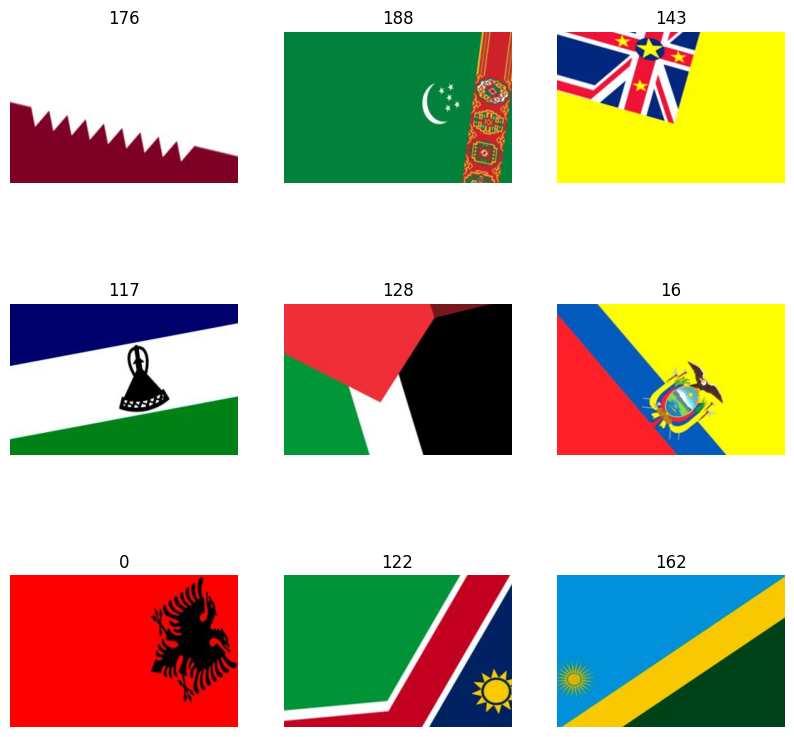

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")